In [1]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [5]:
!pip install -q pandas matplotlib seaborn sentence-transformers faiss-cpu langchain chromadb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 64.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 100.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/55.7 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.5/118.5 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.2/196.2 kB 17.1 MB/s eta

In [1]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('/content/drive/MyDrive/Copy of complaints.csv')

# View the first few rows of the data
df.head()



/tmp/ipython-input-1-1602292929.py:4: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/Copy of complaints.csv')


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,Experian Information Solutions Inc.,FL,32092,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195687
1,2025-06-20,Debt collection,Telecommunications debt,Attempts to collect debt not owed,Debt is not yours,NaN,Company can't verify or dispute the facts in t...,"Eastern Account Systems of Connecticut, Inc.",FL,342XX,NaN,NaN,Web,2025-06-20,Closed with explanation,Yes,NaN,14195688
2,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AZ,85225,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195689
3,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,Experian Information Solutions Inc.,AZ,85225,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195690
4,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Account status incorrect,NaN,NaN,Experian Information Solutions Inc.,IL,60628,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195692


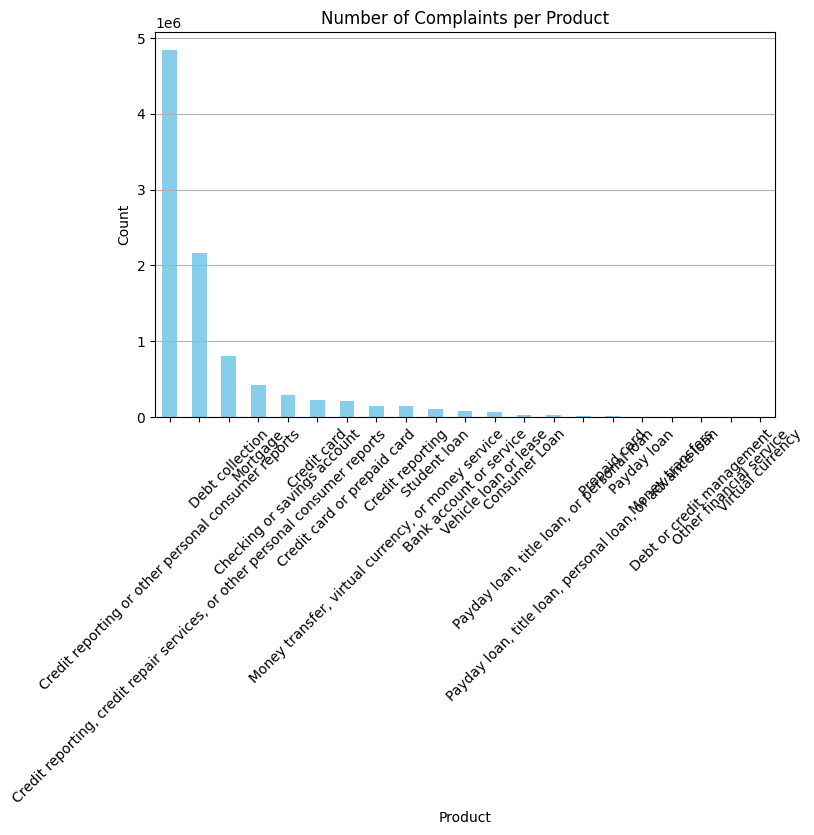

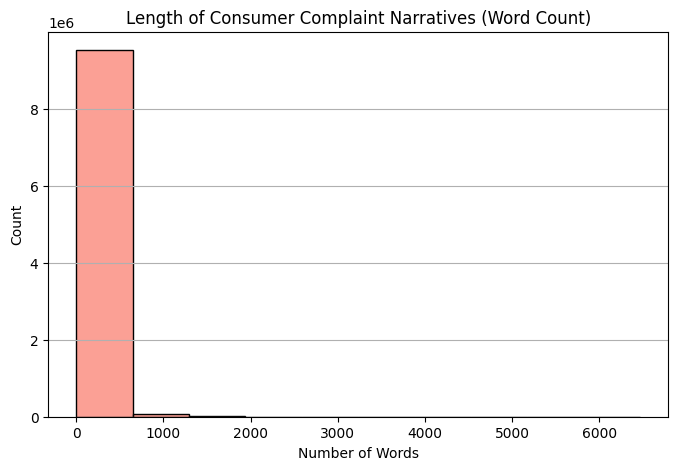

✅ Complaints with narratives: 2980756
❌ Complaints without narratives: 6629041


In [2]:
TARGET_PRODUCTS = ['Credit card', 'Personal loan', 'Buy Now, Pay Later', 'Savings account', 'Money transfer']

filtered_df = df[
    df['Product'].isin(TARGET_PRODUCTS) &
    df['Consumer complaint narrative'].notna()
].copy()

# Clean text
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

filtered_df['cleaned_narrative'] = filtered_df['Consumer complaint narrative'].apply(clean_text)
print("✅ Cleaned and filtered dataset shape:", filtered_df.shape)

# Save filtered data
filtered_df.to_csv("filtered_complaints.csv", index=False)
print("📁 Saved cleaned data to filtered_complaints.csv")

✅ Cleaned and filtered dataset shape: (80667, 19)
📁 Saved cleaned data to filtered_complaints.csv


# Task **2**

In [3]:
import pandas as pd
df = pd.read_csv('/content/filtered_complaints.csv')
print("Loaded cleaned dataset:", df.shape)

Loaded cleaned dataset: (80667, 19)


In [4]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

splitter = RecursiveCharacterTextSplitter(
    chunk_size=300,
    chunk_overlap=50,
    separators=["\n\n", "\n", ".", "!", "?", ",", " ", ""]
)

documents = []
for i, row in df.iterrows():
    chunks = splitter.split_text(row['cleaned_narrative'])
    for chunk in chunks:
        documents.append({
            'complaint_id': row['Complaint ID'] if 'Complaint ID' in row else i,
            'product': row['Product'],
            'text': chunk
        })

print(f"🧠 Total chunks generated: {len(documents)}")


🧠 Total chunks generated: 371743


In [6]:
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np

model = SentenceTransformer('all-MiniLM-L6-v2')
texts = [doc['text'] for doc in documents]
embeddings = model.encode(texts, show_progress_bar=True)

# Create FAISS index
dim = embeddings[0].shape[0]
index = faiss.IndexFlatL2(dim)
index.add(np.array(embeddings))

# Save index and metadata
import os
import pickle

os.makedirs("vector_store", exist_ok=True)
faiss.write_index(index, "vector_store/complaint_index.faiss")

with open("vector_store/metadata.pkl", "wb") as f:
    pickle.dump(documents, f)

print("✅ Vector store saved in 'vector_store/' folder.")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/11617 [00:00<?, ?it/s]

✅ Vector store saved in 'vector_store/' folder.
